In [1]:
import pandas as pd
import numpy as np
import random
import warnings
from IPython.display import display, HTML
from plotnine import *
from plotnine.data import mpg
warnings.filterwarnings('ignore')


# For code PDF - jupyter-nbconvert --to PDFviaHTML PBCCompBal.ipynb
# For no code PDF - jupyter-nbconvert --no-input --to PDFviaHTML PBCCompBal.ipynb

# PBC Competitive Balance Draft
***

The PBC Competitive Balance Draft Rounds A and B are designed to counteract imbalances in the league due simply to differences in the local market sizes of our teams. The 10 teams with the smallest markets (as determined by local media revenue from the previous season) will be eligible for these picks. The order of these picks will be determined by a lottery drawing with each team receiving a certain number of balls based on three components: Local Media Revenue and Market Size. There will be 10 picks awarded. 6 at the end of the first round, and 4 at the end of the 2nd round. The rest of this document outlines this process in detail, and shows the results at each step.


In [14]:
#Season

season = 2039
league_id = 146

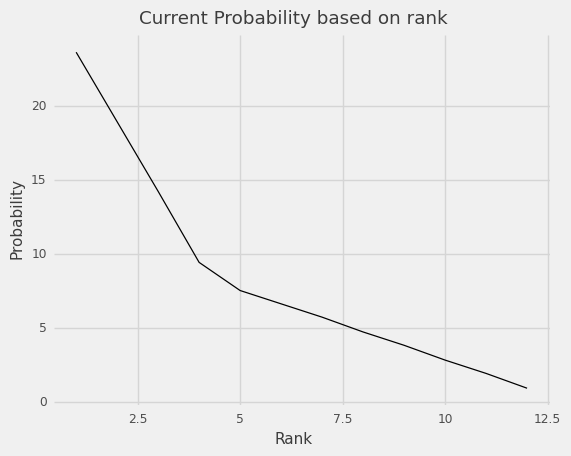

In [15]:
index = [1,2,3,4,5,6,7,8,9,10,11,12]
balls_base = pd.DataFrame([250,200,150,100,80,70,60,50,40,30,20,10], columns = ['Balls'], index = index)
balls_base['Probability'] = round((balls_base['Balls']/sum(balls_base['Balls']))*100,1)
balls_base

(ggplot(balls_base.reset_index()) + aes(x = 'index', y = 'Probability') 
    + geom_line()
    + theme_538()
    + labs(title = 'Current Probability based on rank',
           x = 'Rank',
           y = 'Probability')).draw();

Balls will be assigned according to the above weights twice using the following process.

1. **First of all, any playoff team is disqualified from eligibility.**

1. **Market Size.** This is the team's Market Size during the prior season. The bottom 10 Market Size will be granted eligibility into the competitive balance pool. Balls are assigned by lowest Media Revenue to highest among these bottom 10 teams, with wins as the second sort value. If Market Size AND wins are tied...

    > Tiebreakers are handled by giving the average number of available chances for selection to all tied teams. This means if Teams 1 and 2 are tied, then both teams get the average number of balls between the tied positions (250 + 200 = 450..... 450/2 = 225.)

At this point, we have 10 eligible teams with assigned lottery balls. 

    
2. **Total Revenue.** Total Revenue a team earns in a given season. This is simply sorted from lowest revenue, to highest to determine eligibility. Lowest Revenue gets the most, decreasing down to 10 teams.


Once this is done, we combine BOTH Market Size + Total Revenue, and give a total number of balls for each eligible team. 

Below is a list of all teams, sorted alphabetically with all criteria for selection. 

In [16]:
path = 'C:/Users/night/Documents/Out of the Park Developments/OOTP Baseball 23/saved_games/PBC.lg/import_export/csv/'

teams = pd.read_csv(path + 'teams.csv')
team_history = pd.read_csv(path + 'team_history.csv')
team_financials = pd.read_csv(path + 'team_history_financials.csv')
standings = pd.read_csv(path + 'team_history_record.csv')


team_history = team_history[(team_history['year'] == season - 1) & (team_history['league_id'] == league_id)][['team_id', 'made_playoffs']]
team_financials = team_financials[(team_financials['year'] == season - 1) & (team_financials['league_id'] == league_id)]
standings = standings[(standings['year'] == season - 1) & (standings['league_id'] == league_id)][['team_id', 'w']]

standings = standings.merge(teams, how = 'left',
                            left_on = ['team_id'],
                           right_on = ['team_id'])

standings['Team'] = standings['name'] + ' ' + standings['nickname']
standings = standings[['Team', 'w']]
standings = standings.rename(columns={"w": "Wins"})

comp_balance = team_financials.merge(teams, how = 'left', 
                      left_on = ['team_id','sub_league_id','division_id'], 
                      right_on = ['team_id','sub_league_id','division_id']
                     ).merge(team_history, how = 'left', 
                      left_on = ['team_id'], 
                      right_on = ['team_id'])

comp_balance['Team'] = comp_balance['name'] + ' ' + comp_balance['nickname']
comp_balance['Total Revenue'] = comp_balance['gate_revenue'] + \
                          comp_balance['season_ticket_revenue'] + \
                          comp_balance['media_revenue'] + \
                          comp_balance['merchandising_revenue'] + \
                          comp_balance['playoff_revenue']
comp_balance['Market Size'] = comp_balance['market']
comp_balance['Playoff Team'] = np.where(comp_balance['made_playoffs'] == 1, 'Y','N')
comp_balance['Media Revenue Percentage'] = (comp_balance['media_revenue'] / comp_balance['Total Revenue'])
comp_balance['End of Season Cash'] = comp_balance['cash']
comp_balance = comp_balance[['Team', 'Media Revenue Percentage', 'Market Size', 'Total Revenue', 'End of Season Cash', 'Playoff Team']]

comp_balance = comp_balance.sort_values('Team')
comp_balance.index = np.arange(1,len(comp_balance)+1)
format_dict = {'Media Revenue Percentage':'{:.1%}', 'Total Revenue':'${0:,.0f}', 'End of Season Cash':'${0:,.0f}'}
comp_balance.style.format(format_dict)

comp_balance = comp_balance.merge(standings, how = 'left', left_on = 'Team', right_on = 'Team')
comp_balance = comp_balance[['Team', 'Wins', 'Market Size', 'Total Revenue', 'Playoff Team']]
format_dict = {'Media Revenue Percentage':'{:.1%}', 'Total Revenue':'${0:,.0f}', 'End of Season Cash':'${0:,.0f}'}
comp_balance.style.format(format_dict)

,Team,Wins,Market Size,Total Revenue,Playoff Team
0,Arizona Diamondbacks,53,4,"$86,959,407",N
1,Atlanta Braves,91,5,"$129,274,692",N
2,Baltimore Orioles,95,5,"$139,874,509",Y
3,Boston Red Sox,57,9,"$176,617,942",N
4,Charlotte Bobcats,79,5,"$169,675,470",N
5,Chicago Cubs,61,10,"$182,879,627",N
6,Cincinnati Reds,80,5,"$120,003,669",N
7,Cleveland Guardians,65,5,"$116,689,478",N
8,Colorado Rockies,68,5,"$106,592,147",N
9,Detroit Tigers,83,6,"$187,375,528",N


Playoff teams specifically, are removed from eligibility for Comp Balance Picks. Make the postseason, You're no longer included. Here's the list of the teams that are all eligible, with pertinent information for PBC.

In [21]:
all_teams = comp_balance[comp_balance['Playoff Team'] == 'N'].drop('Playoff Team', axis = 1).reset_index(drop = True)
all_teams.style.format(format_dict)

,Team,Wins,Market Size,Total Revenue
0,Arizona Diamondbacks,53,4,"$86,959,407"
1,Atlanta Braves,91,5,"$129,274,692"
2,Boston Red Sox,57,9,"$176,617,942"
3,Charlotte Bobcats,79,5,"$169,675,470"
4,Chicago Cubs,61,10,"$182,879,627"
5,Cincinnati Reds,80,5,"$120,003,669"
6,Cleveland Guardians,65,5,"$116,689,478"
7,Colorado Rockies,68,5,"$106,592,147"
8,Detroit Tigers,83,6,"$187,375,528"
9,Houston Astros,67,8,"$186,742,071"


## **Market size Eligibiity**

Below are the lowest 10 teams, sorted by Market Size. These 10 teams are eligible for a competitive balance draft pick in the upcoming draft.

As stated above, if the Market Size is tied, all teams recieve an equal share of balls. 

In [22]:
market_10 = all_teams.sort_values(by = ['Market Size', 'Wins']).head(10)[['Team', 'Wins','Market Size']]
market_10.reset_index(drop = True)

,Team,Wins,Market Size
0,Arizona Diamondbacks,53,4
1,Milwaukee Brewers,64,4
2,Oakland Athletics,75,4
3,Cleveland Guardians,65,5
4,Colorado Rockies,68,5
5,Charlotte Bobcats,79,5
6,Cincinnati Reds,80,5
7,Atlanta Braves,91,5
8,Minnesota Twins,82,6
9,Detroit Tigers,83,6


### **How many Lottery Balls are awarded?**

Sort order is as follows: 
* Market Size, low to high
* Wins Low to high

Given no tiebreakers, the distribution of awarded balls requires no tiebreakers. The result is shown below.

In [23]:
# Here's the code to calculate the available balls given the tiebreakers in Market Size.

balls = balls_base.copy(deep = True)
balls.loc[1,'Market Balls'] = balls_base.loc[1,'Balls']
balls.loc[2,'Market Balls'] = balls_base.loc[2,'Balls']
balls.loc[3,'Market Balls'] = balls_base.loc[3,'Balls']
balls.loc[4,'Market Balls'] = balls_base.loc[4,'Balls']
balls.loc[5,'Market Balls'] = balls_base.loc[5,'Balls']
balls.loc[6,'Market Balls'] = balls_base.loc[6,'Balls']
balls.loc[7,'Market Balls'] = balls_base.loc[7,'Balls']
balls.loc[8,'Market Balls'] = balls_base.loc[8,'Balls']
balls.loc[9,'Market Balls'] = balls_base.loc[9,'Balls']
balls.loc[10,'Market Balls'] = balls_base.loc[10,'Balls']
balls = pd.DataFrame(balls['Market Balls'])
balls = balls.astype(float).round(1)

# Code to determine Market Size Eligibility

market_10.index = np.arange(1, len(market_10) + 1)
market = pd.concat([market_10,balls], axis = 1)
market_final = market[['Team','Market Balls']].head(10)
market_final['Market Balls'] = market_final['Market Balls'].apply(np.ceil).astype(int)
market_final

,Team,Market Balls
1,Arizona Diamondbacks,250
2,Milwaukee Brewers,200
3,Oakland Athletics,150
4,Cleveland Guardians,100
5,Colorado Rockies,80
6,Charlotte Bobcats,70
7,Cincinnati Reds,60
8,Atlanta Braves,50
9,Minnesota Twins,40
10,Detroit Tigers,30


## **Revenue Eligibility**

Below are the lowest 10 Total Revenues. If by some freak occurence Total Revenue ends up tied, we will essentially award the average of the total balls awarded between the tied teams. 

In [24]:
# Calculating the eligibility for teams by Revenue

revenue_elig = all_teams.sort_values('Total Revenue', ascending = True)
revenue_elig.index = np.arange(1,len(revenue_elig) +1)
revenue_elig = revenue_elig.join(balls_base).head(10)
revenue_elig.rename(columns = {'Balls': 'Revenue Balls'}, inplace = True)
revenue_elig[['Team', 'Total Revenue']].style.format(format_dict)


,Team,Total Revenue
1,Arizona Diamondbacks,"$86,959,407"
2,Colorado Rockies,"$106,592,147"
3,Texas Rangers,"$115,081,434"
4,Cleveland Guardians,"$116,689,478"
5,Cincinnati Reds,"$120,003,669"
6,Milwaukee Brewers,"$125,371,055"
7,Atlanta Braves,"$129,274,692"
8,Philadelphia Phillies,"$140,479,875"
9,Kansas City Royals,"$147,926,515"
10,Toronto Blue Jays,"$158,033,108"


### **How many Lottery Balls are awarded?**

Given no ties exist, the lottery balls are assigned sequentially. 


In [25]:
revenue_final = revenue_elig[['Team', 'Revenue Balls']].head(10)
revenue_final['Revenue Balls'] = revenue_final['Revenue Balls'].astype(int)
revenue_final

,Team,Revenue Balls
1,Arizona Diamondbacks,250
2,Colorado Rockies,200
3,Texas Rangers,150
4,Cleveland Guardians,100
5,Cincinnati Reds,80
6,Milwaukee Brewers,70
7,Atlanta Braves,60
8,Philadelphia Phillies,50
9,Kansas City Royals,40
10,Toronto Blue Jays,30


## **Final Draft Lottery Probabilities**

For the Comp Balance Lottery, here are the chances provided for each team for the top selection. There's an important distinction to advise you on. This lottery is drawn randomly, without replacement, with a caveat. The process works as follows: 

1. The program draws a ball. The team on the ball is awarded the selection.
2. All corresponding balls from the selected team are removed from the lottery pool.
3. The program then draws another ball, from the remaining pool.
4. All corresponding balls from the selected team are removed from the lottery pool.

This process repeats until the draft is over. So the probabilities you see below are exclusive to the first overall selection. Upon request, I can provide probabilities for each subsequent round if you are interested in seeing it. 

The draft lottery itself is not displayed below, simply the results. The code is provided upon request. 
> Side note: for those interested in the programatic methodology: The process is done through a manual iteration of 10 steps (10 picks) by utilizing the random package in python. The random_choices() method allows us to provide a list of teams, with assigned weights by constructing vectorized operations on those columns in the dataset. From there, we iterate 1 output of random choice. I then reconstruct the dataset to exclude the team selected so as to properly remove them from the process. This process is then repeated until the draft is over. The result is displayed in a custom dictioanry, which is then printed at the end of the process to outline the pick, team, chance of winning pick in that given round, and finally how that % was calculated (balls owned/total balls in that pick)

In [27]:
# Creating the final dataset, by merging Market and Revenue balls.

final = pd.merge(all_teams,market_final, how = 'left', on = 'Team').merge(revenue_final, how = 'left', on = 'Team').fillna(0)

# Calculate total balls available for teams, as well as % chance for selection.
final['Total Balls'] = final['Market Balls'] + final['Revenue Balls']
final['% Pick Chance'] = (final['Total Balls']/sum(final['Total Balls']))

# Limit the dataset to only teams that have lottery balls
final = final[final['Total Balls'] > 0]

# Select the final columns, sorting byy Total Balls (Descending), and Wins (Ascending).
final_cols = ['Team', 'Wins','Market Size', 'Total Revenue', 'Total Balls','% Pick Chance']
final = final[final_cols].sort_values(['Total Balls','Wins'], ascending = [False,True]).set_index('Team')
final['Total Balls'] = final['Total Balls'].astype('int')

final_format = {'% Pick Chance':'{:.1%}', 'Total Revenue':'${0:,.0f}'}
final.style.format(final_format)

,Wins,Market Size,Total Revenue,Total Balls,% Pick Chance
Team,,,,,
Arizona Diamondbacks,53,4,"$86,959,407",500,24.3%
Colorado Rockies,68,5,"$106,592,147",280,13.6%
Milwaukee Brewers,64,4,"$125,371,055",270,13.1%
Cleveland Guardians,65,5,"$116,689,478",200,9.7%
Oakland Athletics,75,4,"$186,324,917",150,7.3%
Texas Rangers,83,6,"$115,081,434",150,7.3%
Cincinnati Reds,80,5,"$120,003,669",140,6.8%
Atlanta Braves,91,5,"$129,274,692",110,5.3%
Charlotte Bobcats,79,5,"$169,675,470",70,3.4%


## Final Results

The following picks will be awarded as follows:

In [28]:
# Lots to unpack here. First, I create a dictionary to store the results, that will allow me to iterate results at the bottom. 
# Secondly, I seed the random drawing. This will vary based on date calculated.
# Finally, each pick is a combination of recalls, and application of the random.choices package, selecting a team at random.
# Code is written to name, and log the results of each pick, as well as calculate the probabilities of each selection occuring.

picks = {}

random.seed(11122022)

first = random.choices(final.index, final['Total Balls'], k = 1)
two = final[final.index != first[0]]
two['% Pick Chance'] = round(two['Total Balls']/sum(two['Total Balls'])*100,1)
picks['Round 1 - Pick C1'] = [first[0],final.loc[final.index == first[0]]['% Pick Chance'][0], final.loc[final.index == first[0]]['Total Balls'][0], sum(final['Total Balls']) ]

second = random.choices(two.index, two['Total Balls'], k = 1)
three = two[two.index != second[0]]
three['% Pick Chance'] = round(three['Total Balls']/sum(three['Total Balls'])*100,1)
picks['Round 1 - Pick C2'] = [second[0],two.loc[two.index == second[0]]['% Pick Chance'][0], two.loc[two.index == second[0]]['Total Balls'][0], sum(two['Total Balls']) ]

third = random.choices(three.index, three['Total Balls'], k = 1)
four = three[three.index != third[0]]
four['% Pick Chance'] = round(four['Total Balls']/sum(four['Total Balls'])*100,1)
picks['Round 1 - Pick C3'] = [third[0],three.loc[three.index == third[0]]['% Pick Chance'][0], three.loc[three.index == third[0]]['Total Balls'][0], sum(three['Total Balls']) ]

fourth = random.choices(four.index, four['Total Balls'], k = 1)
five = four[four.index != fourth[0]]
five['% Pick Chance'] = round(five['Total Balls']/sum(five['Total Balls'])*100,1)
picks['Round 1 - Pick C4'] = [fourth[0],four.loc[four.index == fourth[0]]['% Pick Chance'][0], four.loc[four.index == fourth[0]]['Total Balls'][0], sum(four['Total Balls']) ]

fifth = random.choices(five.index, five['Total Balls'], k = 1)
six = five[five.index != fifth[0]]
six['% Pick Chance'] = round(six['Total Balls']/sum(six['Total Balls'])*100,1)
picks['Round 1 - Pick C5'] = [fifth[0],five.loc[five.index == fifth[0]]['% Pick Chance'][0], five.loc[five.index == fifth[0]]['Total Balls'][0], sum(five['Total Balls']) ]

sixth = random.choices(six.index, six['Total Balls'], k = 1)
seven = six[six.index != sixth[0]]
seven['% Pick Chance'] = round(seven['Total Balls']/sum(seven['Total Balls'])*100,1)
picks['Round 1 - Pick C6'] = [sixth[0],six.loc[six.index == sixth[0]]['% Pick Chance'][0], six.loc[six.index == sixth[0]]['Total Balls'][0], sum(six['Total Balls']) ]

seventh = random.choices(seven.index, seven['Total Balls'], k = 1)
eight = seven[seven.index != seventh[0]].sort_values('Wins', ascending = True)
eight['% Pick Chance'] = round(eight['Total Balls']/sum(eight['Total Balls'])*100,1)
picks['Round 2 - Pick C1'] = [seventh[0],seven.loc[seven.index == seventh[0]]['% Pick Chance'][0], seven.loc[seven.index == seventh[0]]['Total Balls'][0], sum(seven['Total Balls']) ]

eighth = random.choices(eight.index, eight['Total Balls'], k = 1)
nine = eight[eight.index != eighth[0]].sort_values('Wins', ascending = True)
nine['% Pick Chance'] = round(nine['Total Balls']/sum(nine['Total Balls'])*100,1)
picks['Round 2 - Pick C2'] = [eighth[0],eight.loc[eight.index == eighth[0]]['% Pick Chance'][0], eight.loc[eight.index == eighth[0]]['Total Balls'][0], sum(eight['Total Balls']) ]

ninth = random.choices(nine.index, nine['Total Balls'], k = 1)
ten = nine[nine.index != ninth[0]].sort_values('Wins', ascending = True)
ten['% Pick Chance'] = round(ten['Total Balls']/sum(ten['Total Balls'])*100,1)
picks['Round 2 - Pick C3'] = [ninth[0],nine.loc[nine.index == ninth[0]]['% Pick Chance'][0], nine.loc[nine.index == ninth[0]]['Total Balls'][0], sum(nine['Total Balls']) ]

tenth = random.choices(ten.index, ten['Total Balls'], k = 1)
# eleven = ten[ten.index != tenth[0]].sort_values('Wins', ascending = True)
# eleven['% Pick Chance'] = round(eleven['Total Balls']/sum(eleven['Total Balls'])*100,1)
picks['Round 2 - Pick C4'] = [tenth[0],ten.loc[ten.index == tenth[0]]['% Pick Chance'][0], ten.loc[ten.index == tenth[0]]['Total Balls'][0], sum(ten['Total Balls']) ]

# eleventh = random.choices(eleven.index, eleven['Total Balls'], k = 1)
# twelve = eleven[eleven.index != eleventh[0]].sort_values('Wins', ascending = True)
# twelve['% Pick Chance'] = round(twelve['Total Balls']/sum(twelve['Total Balls'])*100,1)
# picks['Round 2 - Pick C5'] = [eleventh[0],eleven.loc[eleven.index == eleventh[0]]['% Pick Chance'][0], eleven.loc[eleven.index == eleventh[0]]['Total Balls'][0], sum(eleven['Total Balls']) ]

# twelveth = random.choices(twelve.index, twelve['Total Balls'], k = 1)
# thirteen = twelve[twelve.index != twelveth[0]].sort_values('Wins', ascending = True)
# thirteen['% Pick Chance'] = round(thirteen['Total Balls']/sum(thirteen['Total Balls'])*100,1)
# picks['Round 2 - Pick C6'] = [twelveth[0],twelve.loc[twelve.index == twelveth[0]]['% Pick Chance'][0], twelve.loc[twelve.index == twelveth[0]]['Total Balls'][0], sum(twelve['Total Balls']) ]

# thirteenth = random.choices(thirteen.index, thirteen['Total Balls'], k = 1)
# picks['Round 2 - Pick C7'] = [thirteenth[0],thirteen.loc[thirteen.index == thirteenth[0]]['% Pick Chance'][0], thirteen.loc[thirteen.index == thirteenth[0]]['Total Balls'][0], sum(thirteen['Total Balls']) ]

picks['Round 1 - Pick C1'][1] = round(picks['Round 1 - Pick C1'][1]*100,1)
for key, value in picks.items():
    print(str(key) +" : " + str(value[0]) + ' - Chance to win pick = ' + str(value[1])+'%' + ' (' + str(value[2]) + '/' + str(value[3]) + ')')

Round 1 - Pick C1 : Cleveland Guardians - Chance to win pick = 9.7% (200/2060)
Round 1 - Pick C2 : Arizona Diamondbacks - Chance to win pick = 26.9% (500/1860)
Round 1 - Pick C3 : Detroit Tigers - Chance to win pick = 2.2% (30/1360)
Round 1 - Pick C4 : Oakland Athletics - Chance to win pick = 11.3% (150/1330)
Round 1 - Pick C5 : Milwaukee Brewers - Chance to win pick = 22.9% (270/1180)
Round 1 - Pick C6 : Colorado Rockies - Chance to win pick = 30.8% (280/910)
Round 2 - Pick C1 : Kansas City Royals - Chance to win pick = 6.3% (40/630)
Round 2 - Pick C2 : Cincinnati Reds - Chance to win pick = 23.7% (140/590)
Round 2 - Pick C3 : Texas Rangers - Chance to win pick = 33.3% (150/450)
Round 2 - Pick C4 : Minnesota Twins - Chance to win pick = 13.3% (40/300)


SyntaxError: invalid syntax (4030603386.py, line 1)